In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.9 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 216, done.
remote: Counting objects

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [29]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2-V1", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 30,
    "batch_size": 64,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 25,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2Reader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [10]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [11]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [31]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True,
                            # dropout=0.1
                            )
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

---

In [13]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [15]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [16]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [17]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [18]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [19]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [20]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [21]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [22]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-22-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-129


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.097



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.097



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.210



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.098



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.098



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.159



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.208



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.256



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.262



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.269



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.267



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.272



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.275



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.328



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.405



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.336



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.458



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.598



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.621



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.621



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.456



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.526



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.584



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.719



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.737



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.744



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.788



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.717



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.803



train:   0%|          | 0/282 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.812



unseen:   0%|          | 0/83 [00:00<?, ?batch/s]

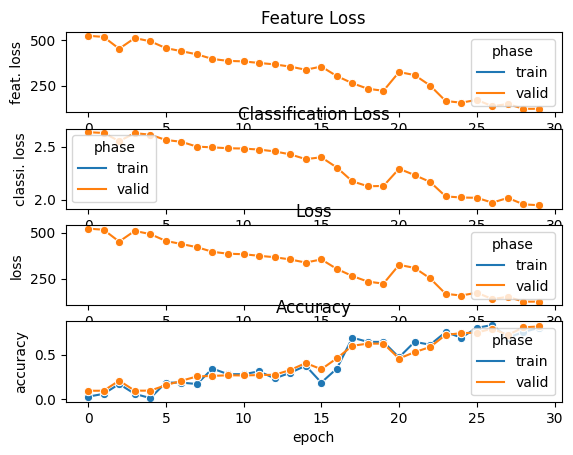

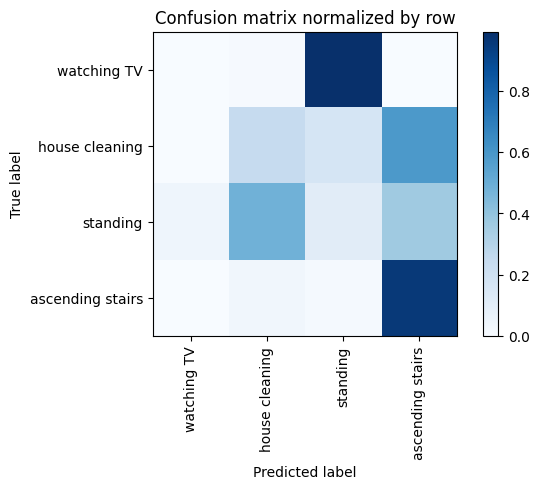

Overall accuracy: 0.285

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.333      0.247      0.284      0.339       1800|	 ascending stairs: 0.585,	standing: 0.168,	
        standing       0.146      0.109      0.125      0.334       1773|	 house cleaning: 0.483,	ascending stairs: 0.365,	
ascending stairs       0.340      0.955      0.502      0.173        918|	 house cleaning: 0.032,	standing: 0.012,	
     watching TV       0.000      0.000      0.000      0.155        821|	 standing: 0.991,	house cleaning: 0.009,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.220      0.285      0.224        1.0       5312|	      

{'accuracy': 0.28520331325301207, 'precision': 0.20477906746168284, 'recall': 0.3278537401988432, 'f1': 0.2275694676855214, 'samples': 5312, 'loss': 3073256.05078125, 'feat. loss': 3073255.39453125, '

Training Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.083



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.084



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.084



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.084



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.064



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.109



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.136



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.173



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.258



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.327



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.311



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.416



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.396



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.487



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.489



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.571



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.487



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.586



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.577



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.606



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.449



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.578



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.587



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.568



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.591



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.585



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.644



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.609



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.764



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.675



unseen:   0%|          | 0/81 [00:00<?, ?batch/s]

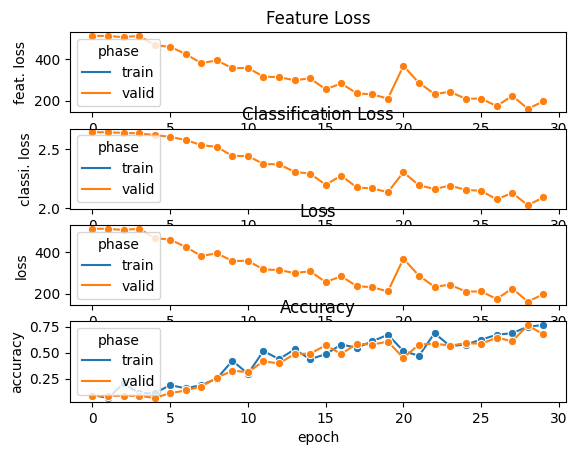

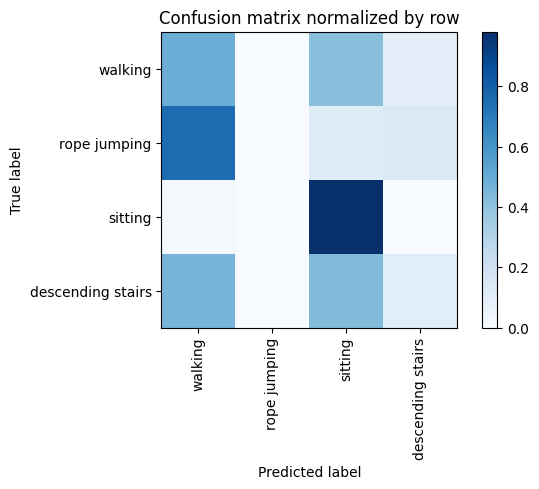

Overall accuracy: 0.552

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.601      0.492      0.541      0.433       2247|	 sitting: 0.412,	descending stairs: 0.096,	
          sitting       0.561      0.981      0.714      0.329       1705|	 walking: 0.018,	descending stairs: 0.001,	
descending stairs       0.227      0.106      0.144      0.149        775|	 walking: 0.462,	sitting: 0.432,	
     rope jumping       0.000      0.000      0.000      0.088        457|	 walking: 0.753,	descending stairs: 0.136,	sitting: 0.112,	

----------------------------------------------------------------------------------------------------
      avg / total       0.479      0.552      0.491        1.0       5184|	      

{'accuracy': 0.5518904320987654, 'precision': 0.3473043656799567, 'recall': 0.3948124902933465, 'f1': 0.3498279818311959, 'samples': 5184, 'loss': 2490579.490234375, 'feat. loss': 2490578.861328125, 'classi. loss': 

Training Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.087



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.088



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.085



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.107



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.184



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.129



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.199



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.047



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.131



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.195



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.129



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.204



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.224



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.254



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.282



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.328



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.318



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.343



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.373



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.274



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.391



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.391



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.425



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.325



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.470



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.424



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.539



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.541



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.420



train:   0%|          | 0/260 [00:00<?, ?batch/s]

seen:   0%|          | 0/28 [00:00<?, ?batch/s]

Overall accuracy: 0.215



unseen:   0%|          | 0/108 [00:00<?, ?batch/s]

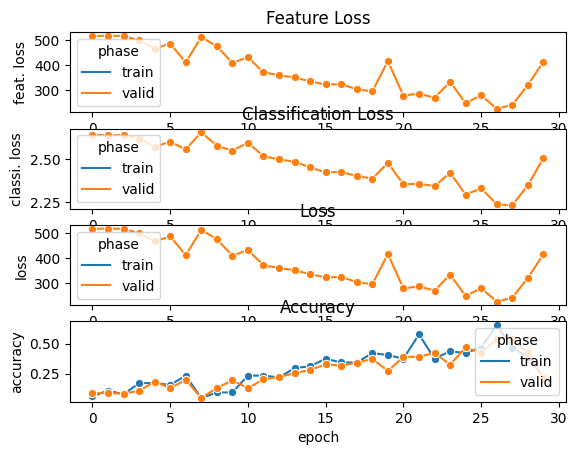

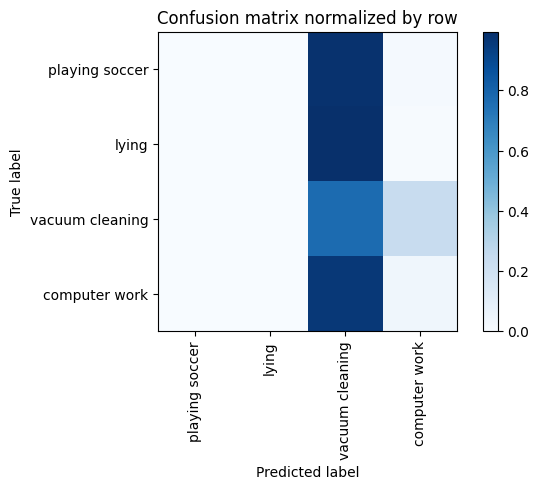

Overall accuracy: 0.197

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.224      0.038      0.064      0.439       3031|	 vacuum cleaning: 0.962,	lying: 0.000,	
          lying       0.500      0.001      0.001      0.260       1796|	 vacuum cleaning: 0.995,	computer work: 0.004,	
vacuum cleaning       0.195      0.766      0.310      0.235       1627|	 computer work: 0.234,	lying: 0.001,	
 playing soccer       0.000      0.000      0.000      0.066        458|	 vacuum cleaning: 0.987,	computer work: 0.013,	lying: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.274      0.197      0.102        1.0       6912|	      

{'accuracy': 0.19690393518518517, 'precision': 0.2297590319954148, 'recall': 0.20099870428110006, 'f1': 0.09397805421997633, 'samples': 6912, 'loss': 3775103.294921875, 'feat. loss': 3775102.1640625, 'classi. loss': 10685

Training Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.084



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.083



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.083



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.061



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.048



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.088



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.062



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.129



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.336



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.222



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.133



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.138



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.161



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.131



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.179



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.362



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.360



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.341



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.511



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.542



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.531



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.601



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.618



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.591



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.484



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.292



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.472



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.607



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.652



train:   0%|          | 0/298 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.585



unseen:   0%|          | 0/65 [00:00<?, ?batch/s]

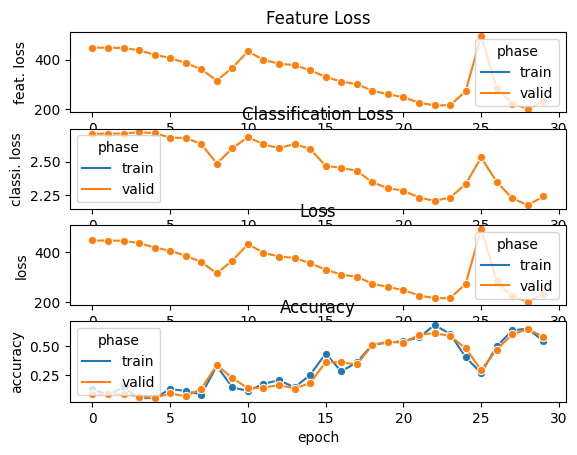

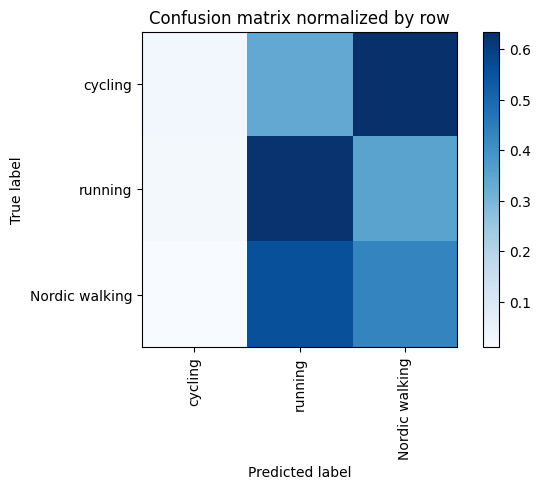

Overall accuracy: 0.325

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.373      0.432      0.400      0.422       1756|	 running: 0.558,	cycling: 0.011,	
       cycling       0.519      0.028      0.053      0.365       1517|	 Nordic walking: 0.634,	running: 0.338,	
       running       0.271      0.625      0.378      0.213        887|	 Nordic walking: 0.353,	cycling: 0.023,	

----------------------------------------------------------------------------------------------------
   avg / total       0.404      0.325      0.269        1.0       4160|	      

{'accuracy': 0.32548076923076924, 'precision': 0.38737958830094504, 'recall': 0.3613087731913887, 'f1': 0.2768138256815965, 'samples': 4160, 'loss': 3067676.0078125, 'feat. loss': 3067675.5, 'classi. loss': 4788.283088684082, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5

Training Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.073



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.071



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.071



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.071



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.058



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.137



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.150



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.159



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.147



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.201



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.057



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.132



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.146



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.210



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.297



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.294



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.420



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.358



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.397



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.414



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.491



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.481



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.480



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.554



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.573



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.597



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.596



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.649



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.652



train:   0%|          | 0/305 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.735



unseen:   0%|          | 0/58 [00:00<?, ?batch/s]

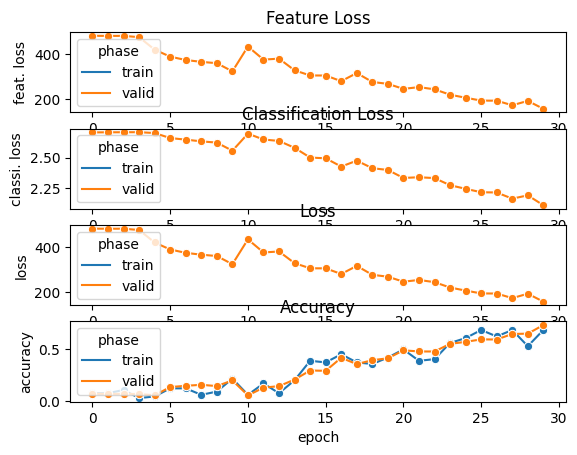

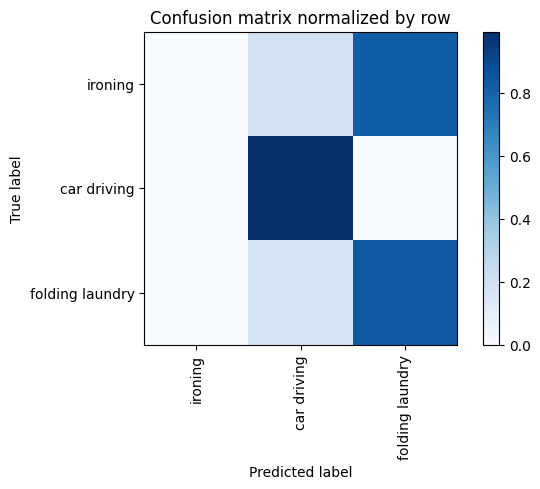

Overall accuracy: 0.354

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.603       2238|	 folding laundry: 0.819,	car driving: 0.181,	
folding laundry       0.302      0.834      0.443      0.256        952|	 car driving: 0.166,	ironing: 0.000,	
    car driving       0.481      0.996      0.648      0.141        522|	 folding laundry: 0.004,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.145      0.354      0.205        1.0       3712|	      

{'accuracy': 0.35398706896551724, 'precision': 0.26083087930392246, 'recall': 0.6100673986069524, 'f1': 0.36390226740983017, 'samples': 3712, 'loss': 2546277.015625, 'feat. loss': 2546276.5625, 'classi. loss': 4389.1818923950195, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.343022
precision    0.281778
recall   

In [32]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['seq_len'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
